In [7]:
import warnings
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [8]:
def make_fourier(na, nb):
    """ The function for the curve fit
    Parameters
    ----------
    na: (int)
        number of cosine terms/coefficients
    nb: (int)
        number of sin terms/coefficients
    """
    def fourier(x, *a):
        ret = a[0]
        for deg in range(0, na):
            ret += a[deg + 1] * np.cos((deg + 1) * np.pi * x / 12)
        for deg in range(na, na+nb):
            ret += a[deg + 1] * np.sin((deg - na + 1) * np.pi * x / 12)
        return ret
    return fourier

In [9]:
def fourier_fit(local_times, drifts, num_co):
    """ Here the terms in the fourier fit are actually determined
    Parameters
    ----------
    local_times : (array-like)
        xdim for fit; local time values
    drifts : (array-like)
        ydim for fit; median drift values from data
    num_co : (int)
        'number of coefficients) how many sin/cosine pairs for the fit

    Returns
    -------
    ve01 : float
        linear offset of the fourier fit
    coefficients : num_co by 2 array like
        coefficients to describe the fourier function that fits the drifts
    """
    coefficients = np.zeros((num_co, 2))
    ind, = np.where(~np.isnan(drifts))
    if ind.size < num_co*2+1:
        warnings.warn('not enough viable drift data, '
                      'returning zero value \"flat fit\"', Warning)
        return 0, coefficients
    # popt contains the coeficients. First ten are cosines, second ten are sins
    popt, pcov = curve_fit(make_fourier(num_co, num_co), local_times[ind],
                           drifts[ind], [0.0]*(num_co*2+1))
    # format the coefficients for input ito the SAMI2 model
    # the shape is np.zeroes((10,2))
    ve01 = popt[0]
    for n in range(1, num_co*2):
        i = (n - 1) % num_co
        j = int((n - 1) / num_co)
        coefficients[i, j] = popt[n]

    return ve01, coefficients

In [10]:
def exb_calc(coefficients, ve01, t):
    '''
    Parameters
    ----------
    coefficients : (array)
        10x2 array of Fourier coefficients
    ve01 : (float)
        flat offset for fourier function 0 by default
    t : (float)
        time in hours
    '''
    exb = ve01
    for i, term in enumerate(coefficients):
        a = term[0]
        b = term[1]
        exb += ((a * np.cos((i+1) * t * np.pi / 12)) +
                (b * np.sin((i+1) * t * np.pi / 12)))
    return exb

In [11]:
def sinusoidal_drifts(amplitude=30):
    """Simple sinusoidal drifts with a positive peak in amplitude near noon
    """
    coef = np.array([[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

    drift = []
    time = np.linspace(0, 24, 49)

    for t in time:
        d = exb_calc(coef, 0, t)
        drift.append(d)

    drift = np.array(drift)
    drift = amplitude*drift
    return drift

In [12]:
def sinusoidal_pre_drifts(amplitude=30):
    """Simple sinusoidal drifts with a positive peak in amplitude near noon
        and a smaller second peak near dusk roughly simulating a pre-reversal
        enhancement
    """
    drift = sinusoidal_drifts()
    time = np.linspace(0, 24, 49)

    # add in the pre reversal enhancement
    drift[37] = 10
    drift[38] = 20
    drift[39] = np.mean([20, drift[40]])

    # compute new coefficients
    pre_v0, pre_coeff = fourier_fit(time, drift, 10)

    # make new time series from those coefficients
    fit_drift = []
    for t in time:
        d = exb_calc(pre_coeff, 0, t)
        fit_drift.append(d)

    fit_drift = np.array(fit_drift)
    return drift, fit_drift, pre_v0, pre_coeff

In [13]:
drift, fit_drift, pre_v0, pre_coeff = sinusoidal_pre_drifts()

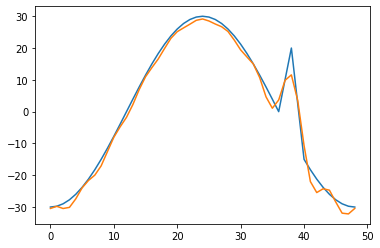

In [15]:
plt.plot(drift)
plt.plot(fit_drift)
plt.show()

In [16]:
pre_coeff

array([[-2.94315409e+01, -2.23048124e+00],
       [-2.00340053e+00, -1.14040270e+00],
       [-1.60765077e+00,  1.57663052e+00],
       [ 1.05101032e+00,  1.87430084e+00],
       [ 1.97903113e+00, -5.36501104e-01],
       [-2.76541726e-02, -1.97875942e+00],
       [-1.82992582e+00, -4.84621146e-01],
       [-9.00598166e-01,  1.50401033e+00],
       [ 1.10122741e+00,  1.13431153e+00],
       [ 1.23414180e+00,  0.00000000e+00]])